In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import os

In [2]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [88]:
userhome = os.path.expanduser('~')
df = pd.read_csv(userhome + r'/Desktop/Parking Performance/locationfactor/parkingdata_20200821.csv')

In [ ]:
#userhome = os.path.expanduser('~')
#df = pd.read_csv(userhome + r'/Desktop/Parking Performance/cluster/20200911/locationfactor.csv')

In [ ]:
#df.info()

In [ ]:
#del df['stationid']
#del df['stationcode_x']
#del df['No. of parking']
#del df['No. of Service Vehicle days']
#del df['No. of Service Vehicle/days']
#del df['Cost/Parking']
#del df['Offline marketing']
#del df['Zone']
#df = pd.get_dummies(df)

In [58]:
del df['TRUE']
del df['stationcode']
del df['No. of parking']
del df['No. of Service Vehicle days']
del df['No. of Service Vehicle/days']
del df['Cost/Parking']
del df['Offline marketing']
del df['Zone']
del df['hotel']
#del df['office']
#del df['shopping mall/convenient store_FALSE']
del df['gas station']
df = pd.get_dummies(df)

In [59]:
df.rename(columns={'UT':'%UT'},inplace=True)

In [60]:
df['UT']=''

In [61]:
df['UT'] = np.where(df['%UT']>=14, 'VG', df['UT'])
df['UT'] = np.where((df['%UT']<14) & (df['%UT']>=9), 'G', df['UT'])
df['UT'] = np.where((df['%UT']<9) & (df['%UT']>=4), 'F', df['UT'])
df['UT'] = np.where(df['%UT']<4, 'P', df['UT'])

In [62]:
df['UT'].unique()

array(['G', 'VG', 'F', 'P'], dtype=object)

In [63]:
del df['%UT']

In [39]:
#MAPE function
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [72]:
ranks = {}

In [73]:
def ranking(ranks, names, order=1):
    ranks = (order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [64]:
df_UT = df[df['UT'].isnull()==False]

In [65]:
y1 = df_UT.UT.values
x1 = df_UT.drop(['UT'], axis = 1)
colnames = x1.columns

In [66]:
rf1 = RandomForestClassifier(n_jobs=-1, n_estimators=1000, min_samples_leaf=1, verbose=1)
rf1.fit(x1,y1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.0s finished


RandomForestClassifier(n_estimators=1000, n_jobs=-1, verbose=1)

In [67]:
y1_pred = rf1.predict(x1)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.1s finished


In [71]:
print("Accuracy:",metrics.accuracy_score(y1, y1_pred))

Accuracy: 0.5256410256410257


In [74]:
ranks["RF1"] = ranking(rf1.feature_importances_, colnames);

In [75]:
feature_imp = pd.Series(rf1.feature_importances_,colnames).sort_values(ascending=False)
feature_imp

Masstransit                             0.237481
university                              0.204642
residential (condo, apartment)          0.186158
office                                  0.121870
shopping mall/convenient store_FALSE    0.095532
shopping mall/convenient store_S        0.085347
shopping mall/convenient store_L        0.068969
dtype: float64

In [76]:
# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	RF1	Mean
residential (condo, apartment)	0.19	0.19
university	0.2	0.2
office	0.12	0.12
Masstransit	0.24	0.24
shopping mall/convenient store_FALSE	0.1	0.1
shopping mall/convenient store_L	0.07	0.07
shopping mall/convenient store_S	0.09	0.09


In [77]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['UT','Feature Importance'])

# Sort the dataframe
meanplot = meanplot.sort_values('Feature Importance', ascending=False)

/Users/wichphoopoonnasee/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/wichphoopoonnasee/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


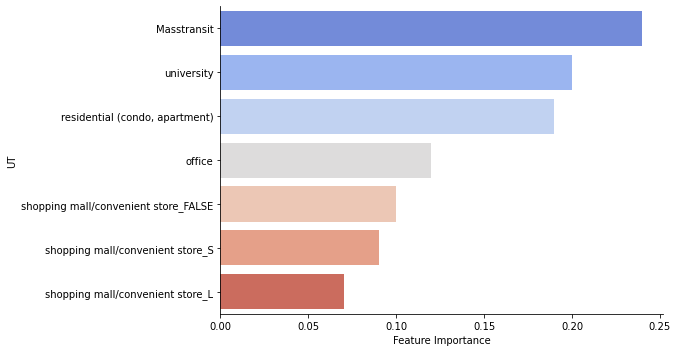

In [78]:
# Let's plot the ranking of the features
sns.factorplot(x="Feature Importance", y="UT", data = meanplot, kind="bar", 
               size=5, aspect=1.9, palette='coolwarm')

In [79]:
userhome = os.path.expanduser('~')
df_all = pd.read_csv(userhome + r'/Desktop/Parking Performance/locationfactor/allscenario2.csv')

In [80]:
yall_pred = rf1.predict(df_all)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.1s finished


In [81]:
df1=pd.DataFrame(data=yall_pred)

In [82]:
df2=pd.concat([df_all,df1], axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
matrix = classification_report(y1,y1_pred,labels=['S','A','B','C'])

In [ ]:
print('Classification report : \n',matrix)

In [ ]:
df1=pd.DataFrame(data=y1)

In [ ]:
df2=pd.DataFrame(data=y1_pred)

In [ ]:
df_pred=pd.concat([df1,df2], axis=1)

In [86]:
df3=pd.DataFrame(data=y1_pred)

In [90]:
df_new=pd.concat([df3,df], axis=1)

In [ ]:
userhome = os.path.expanduser('~')
df_a = pd.read_csv(userhome + r'/Desktop/Parking Performance/locationfactor/result_20200912.csv')

In [ ]:
df_a=df_a.set_index(['TRUE','stationcode'])

In [ ]:
df_a

In [ ]:
S=df_a[df_a['pred']=='S']
A=df_a[df_a['pred']=='A']
B=df_a[df_a['pred']=='B']
C=df_a[df_a['pred']=='C']

In [ ]:
S_mean=S.agg(['mean'])
A_mean=A.agg(['mean'])
B_mean=B.agg(['mean'])
C_mean=C.agg(['mean'])

In [ ]:
class_df=pd.concat([S_mean,A_mean,B_mean,C_mean], axis=0)

In [ ]:
class_df.to_csv('mean.csv')